# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [211]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Open the training and validation datasets

In [212]:
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

display the pixles

In [213]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

creates the y and x traing and validation datasets

In [214]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [215]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into valition and test.
    '''

    if shuffle:
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

    split_index = int((1 - pct) * len(x))

    x_val, x_test = x[:split_index], x[split_index:]
    y_val, y_test = y[:split_index], y[split_index:]

    return x_val, y_val, x_test, y_test

In [216]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

removes the j and z letters

In [ ]:
alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise

In [ ]:
def normalise(x_mean, x_std, x_data):
    """
    standard normalization method for the datasets
    """
    return (x_data - x_mean) / x_std

creates the calculations average and standard deviation from the training dataset


normalise the x datasets

In [219]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

the standard deviation is almost perfect

In [220]:
x_train.mean(), x_train.std()

(np.float32(3.6268384e-06), np.float32(0.99999946))

### Graficar muestras

In [ ]:
def plot_image(image):
  """
    this function displays the plot of the hand
    """
  plt.figure(figsize=(5, 5))
  plt.imshow(image.reshape(28, 28), cmap=plt.get_cmap('gray'))
  plt.axis('off')
  plt.show()

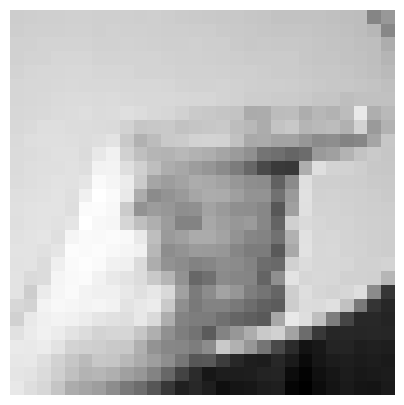

In [222]:
rnd_idx = np.random.randint(len(y_test))
plot_image(x_test[rnd_idx])

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [ ]:
def create_minibatches(mb_size, x, y, shuffle=True):
    """
    Creates mini batches from the datasets where y and x have the same sizes and mix it up 
    to have different combinations in the new x and y 
    """
    assert x.shape[0] == y.shape[0], 'Error: number of samples do not match'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Nuestra clase Linear, ReLU y Sequential

###  Clase Linear

class to convert the np array to a np tensor

In [224]:
class np_tensor(np.ndarray): pass

Creates the fully connected layer of the neural network that adds the layer parameters

In [225]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X): # esta el foward de la clase lineal
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)    


### Clase ReLU

Creates the Rectified Linear Unit activation function

In [226]:
class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Clase Sequential

Creates the organization of the multiple layers

In [227]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X 
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))            

### Cost Function

In [ ]:
def softmaxXEntropy(x, y):
    """
    Calculates the softmax entropy loss 
    """
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis=0)
    preds = probs.copy()
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    probs[y.squeeze(), np.arange(batch_size)] -= 1
    x.grad = probs.copy()
    
    return preds, cost

### Loop de entrenamiento

In [ ]:
def train(model, epochs, mb_size=128, learning_rate=1e-3):
  """
  creates a double iteration where it iterates for every mini batch
  for every epoch, having multiple trainings in total for every epoch
  """
  for epoch in range(epochs):
    for i, (x_batch, y_batch) in enumerate(create_minibatches(mb_size, x_train, y_train)):
      scores = model(x_batch.T.view(np_tensor))
      _, cost = softmaxXEntropy(scores, y_batch)
      model.backward()
      model.update(learning_rate)
    print(f'Epoch {epoch+1}, Cost: {cost}, Accuracy: {accuracy(x_val, y_val, mb_size)}')


In [ ]:
def accuracy(x, y, mb_size):
  """
  creates two counting variables for the correct predictions and total predictions
  it creates a lopp for the mini batches and the x and y datasets
  evrytime it makes a prediction it sums a +1 for each variables
  and returns the accuracy that is the division between the correct and total predictions
  """
  correct = 0
  total = 0
  for i, (x_batch, y_batch) in enumerate(create_minibatches(mb_size, x, y)):
    pred = model(x_batch.T.view(np_tensor))
    correct += np.sum(np.argmax(pred, axis=0) == y_batch.squeeze())
    total += pred.shape[1]
  return correct / total

### Create your model and train it

inputs variables

In [231]:
mb_size = 512
learning_rate = 1e-3
epochs = 30

In [232]:
input_size = 784
layer_size = 784
output_size = 24

model inputs that include the previous formulas with the input, outputs and hyperparameters

In [233]:
model = Sequential_layers([Linear(input_size, layer_size), ReLU(), Linear(layer_size, layer_size), ReLU(), Linear(layer_size, output_size)])

Notes:
- mb size: 512 well enough
- learning rate: this was the fastest but more accurate time learning rate
- epoch: 30 gave us enogh room to get an 80% accuracy
- input and layer size: both are the same so we can max out the input for all with the flattened grayscale image 
- output size: 24 as 24 letter of the alphabet

The chosen architecture and hyperparameters are well-suited for training on the dataset efficiently and effectively. A mini-batch size of 512 provides a balance between computational efficiency and stable gradient updates, while the learning rate was selected as the fastest value ensuring convergence without sacrificing accuracy. 

Training for 30 epochs allowed the model to achieve approximately 80% accuracy without overfitting.


The input size matches the flattened grayscale image dimensions, ensuring all features are fully utilized, and the layer size matches the input size to maximize learning capacity across layers.

The output size of 24 corresponds to the number of alphabet letters, enabling direct classification. 

The architecture consists of an initial `Linear` layer to map the input to a meaningful feature space, followed by `ReLU` activation for non-linear transformations, a second `Linear` layer to refine these features, another `ReLU` for preserving non-linearity, and a final `Linear` layer to map the processed features to 24 output classes. 

### Test your model on Random data from your test set

displays the cost and accuracy based on the number of epochs

In [234]:
train(model, epochs, mb_size, learning_rate)

Epoch 1, Cost: 0.2704748294189386, Accuracy: 0.7551589514779699
Epoch 2, Cost: 0.024126163059674174, Accuracy: 0.7836029001673174
Epoch 3, Cost: 0.01315936264131293, Accuracy: 0.790574456218628
Epoch 4, Cost: 0.006694677738710102, Accuracy: 0.7961517010596765
Epoch 5, Cost: 0.0061557894741264396, Accuracy: 0.7975460122699386
Epoch 6, Cost: 0.003334723165528755, Accuracy: 0.7989403234802008
Epoch 7, Cost: 0.0030561412448237165, Accuracy: 0.7992191857222533
Epoch 8, Cost: 0.0025272154282552795, Accuracy: 0.7997769102063581
Epoch 9, Cost: 0.0019464064957241517, Accuracy: 0.7992191857222533
Epoch 10, Cost: 0.0019771314528887825, Accuracy: 0.7989403234802008
Epoch 11, Cost: 0.00193435033274809, Accuracy: 0.8008923591745678
Epoch 12, Cost: 0.0013556707707365213, Accuracy: 0.7997769102063581
Epoch 13, Cost: 0.001281509420970611, Accuracy: 0.8014500836586727
Epoch 14, Cost: 0.0011889288688571816, Accuracy: 0.8008923591745678
Epoch 15, Cost: 0.0010650517197974502, Accuracy: 0.8017289459007251
E

calculates the total accuracy of the model

In [235]:
print(f"Test Accuracy: %{accuracy(x_test, y_test, mb_size) * 100}")

Test Accuracy: %81.23257110987171


standarize the alfabet by putting it in lower case and removing j and z letters

In [236]:
alphabet = list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')

calculates a random number


displays the random number 


prediction of the random number


print the real and predicted value

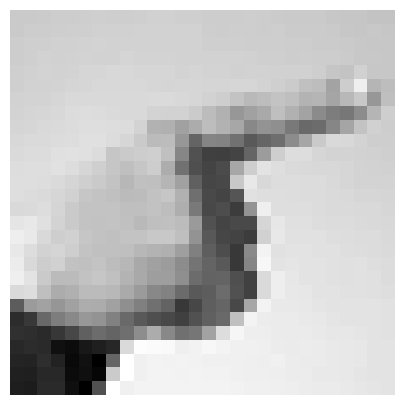

Predicted label: g, Actual label: g


In [257]:
idx = np.random.randint(len(y_test))

plot_image(x_test[idx])

pred = model.predict(x_test[idx].reshape(-1, 1))
pred_char = alphabet[pred]
actual_char = alphabet[y_test[idx]]

print(f"Predicted label: {pred_char}, Actual label: {actual_char}")
